In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [71]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [72]:
print("{} rows and {} features in train set".format(df_train.shape[0], df_train.shape[1]))
print("{} rows and {} features in test set".format(df_test.shape[0], df_test.shape[1]))

27100 rows and 18 features in train set
18050 rows and 17 features in test set


<Axes: >

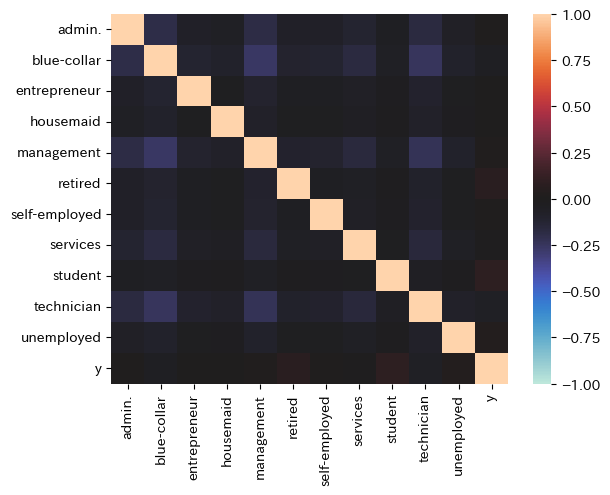

In [73]:
# job と yes/no の相関

df_job_y = df_train[['job', 'y']].copy(deep=True)

df_job_y_EDA = pd.get_dummies(df_job_y['job'])
df_job_y_EDA = df_job_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_job_y_EDA.corr(), vmax=1, vmin=-1, center=0)

<Axes: >

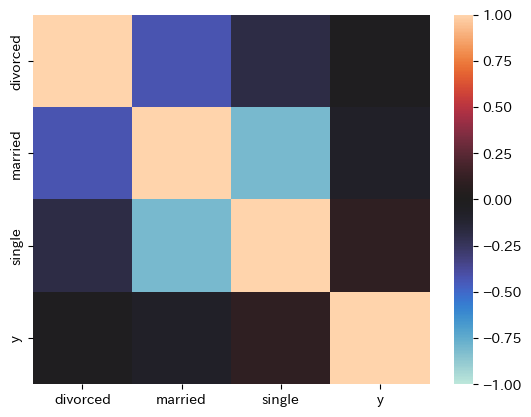

In [74]:
# marital と yes/no の相関

df_marital_y = df_train[['marital', 'y']].copy(deep=True)

df_marital_y_EDA = pd.get_dummies(df_marital_y['marital'])
df_marital_y_EDA = df_marital_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_marital_y_EDA.corr(), vmax=1, vmin=-1, center=0)

education
secondary    15955
tertiary      6737
primary       3329
unknown       1079
Name: count, dtype: int64

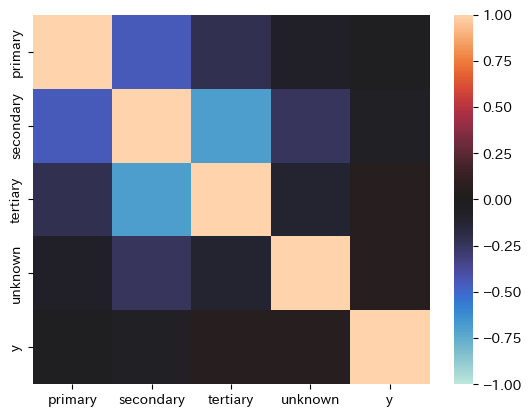

In [75]:
# education と yes/no の相関

df_education_y = df_train[['education', 'y']].copy(deep=True)

df_education_y_EDA = pd.get_dummies(df_education_y['education'])
df_education_y_EDA = df_education_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_education_y_EDA.corr(), vmax=1, vmin=-1, center=0)

df_education_y['education'].value_counts()

<Axes: >

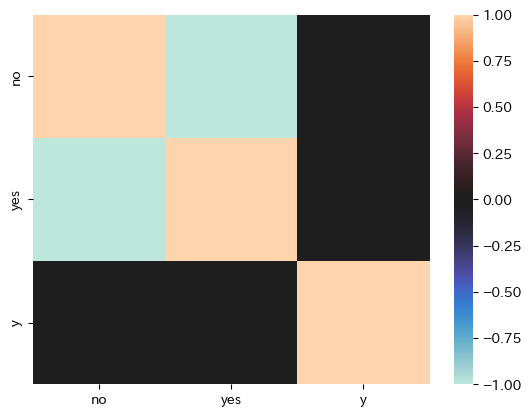

In [76]:
# default と yes/no の相関

df_default_y = df_train[['default', 'y']].copy(deep=True)

df_default_y_EDA = pd.get_dummies(df_default_y['default'])
df_default_y_EDA = df_default_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_default_y_EDA.corr(), vmax=1, vmin=-1, center=0)

<Axes: >

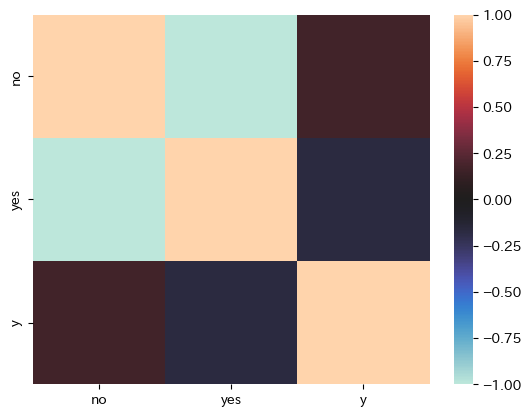

In [77]:
# housing と yes/no の相関

df_housing_y = df_train[['housing', 'y']].copy(deep=True)

df_housing_y_EDA = pd.get_dummies(df_housing_y['housing'])
df_housing_y_EDA = df_housing_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_housing_y_EDA.corr(), vmax=1, vmin=-1, center=0)

<Axes: >

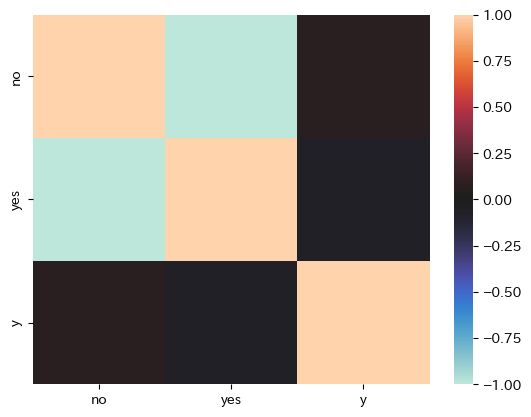

In [78]:
# loan と yes/no の相関

df_loan_y = df_train[['loan', 'y']].copy(deep=True)

df_loan_y_EDA = pd.get_dummies(df_loan_y['loan'])
df_loan_y_EDA = df_loan_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_loan_y_EDA.corr(), vmax=1, vmin=-1, center=0)

<Axes: >

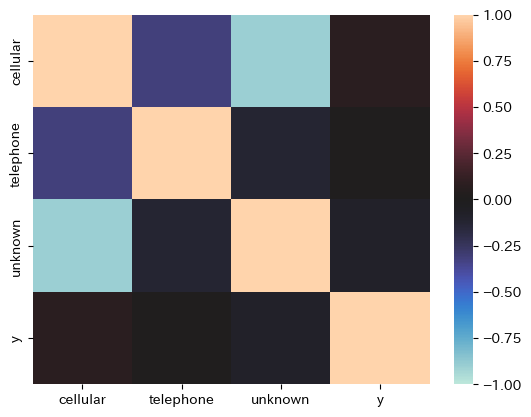

In [79]:
# contact と yes/no の相関

df_contact_y = df_train[['contact', 'y']].copy(deep=True)

df_contact_y_EDA = pd.get_dummies(df_contact_y['contact'])
df_contact_y_EDA = df_contact_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_contact_y_EDA.corr(), vmax=1, vmin=-1, center=0)

<Axes: >

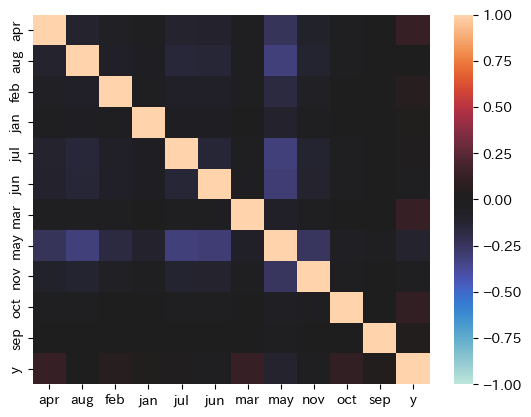

In [80]:
# month と yes/no の相関

df_month_y = df_train[['month', 'y']].copy(deep=True)

df_month_y_EDA = pd.get_dummies(df_month_y['month'])
df_month_y_EDA = df_month_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_month_y_EDA.corr(), vmax=1, vmin=-1, center=0)

<Axes: >

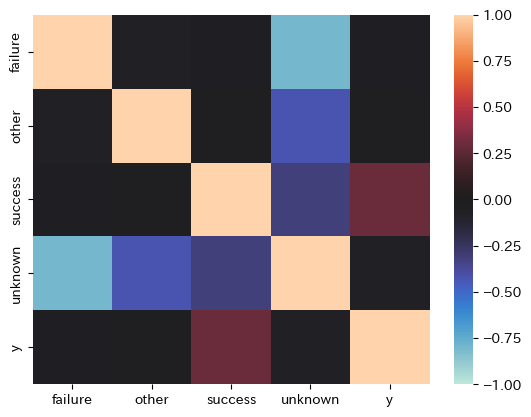

In [81]:
# poutcome と yes/no の相関

df_poutcome_y = df_train[['poutcome', 'y']].copy(deep=True)

df_poutcome_y_EDA = pd.get_dummies(df_poutcome_y['poutcome'])
df_poutcome_y_EDA = df_poutcome_y_EDA.join(df_train['y'].replace(['no', 'yes'], [0, 1]))

sns.heatmap(df_poutcome_y_EDA.corr(), vmax=1, vmin=-1, center=0)

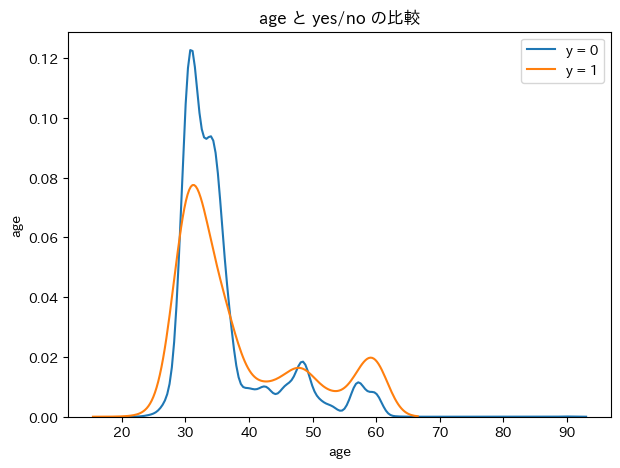

age
31    4464
30    3226
35    2888
34    2521
33    2318
32    2176
37    1368
29    1104
36     907
49     683
48     675
57     573
60     546
46     435
43     385
40     333
42     307
51     279
39     270
45     252
53     236
58     222
27     222
41     153
59     116
47     115
56     104
28      66
44      39
25      35
50      18
38      12
55      11
26      10
24       8
63       6
52       5
90       5
54       4
22       1
77       1
73       1
Name: count, dtype: int64

In [82]:
# age と yes/no の比較
plt.figure(figsize=(7, 5))
sns.kdeplot(df_train[df_train['y'] == 0]['age'], label='y = 0')
sns.kdeplot(df_train[df_train['y'] == 1]['age'], label='y = 1')
plt.legend()
plt.title('age と yes/no の比較')
plt.ylabel('age')
plt.show()
df_train['age'].value_counts()

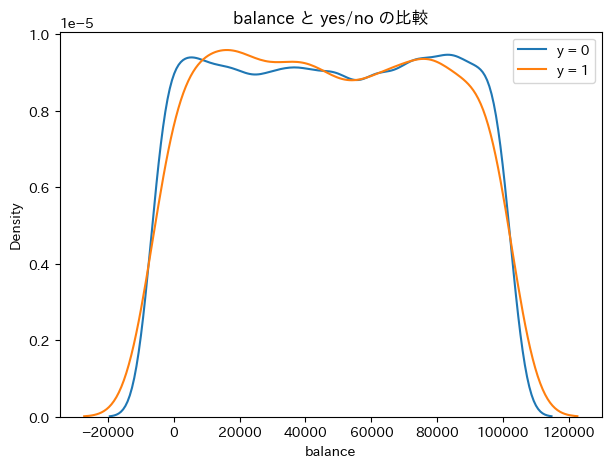

balance
66114    4
73975    4
20377    4
13344    4
13392    4
        ..
17532    1
68057    1
63988    1
44037    1
8657     1
Name: count, Length: 23967, dtype: int64

In [83]:
# balance と yes/no の比較
plt.figure(figsize=(7, 5))
sns.kdeplot(df_train[df_train['y'] == 0]['balance'], label='y = 0')
sns.kdeplot(df_train[df_train['y'] == 1]['balance'], label='y = 1')
plt.legend()
plt.title('balance と yes/no の比較')
plt.xlabel('balance')
plt.show()
df_train['balance'].value_counts()

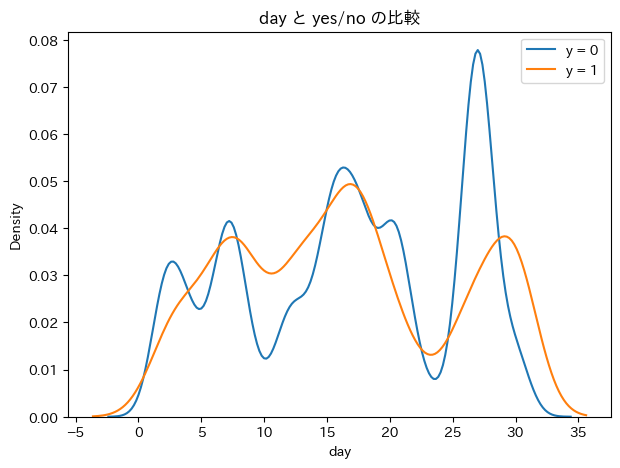

day
27    4129
7     1919
18    1732
20    1693
16    1681
2     1495
15    1451
21    1328
17    1285
26    1172
30    1144
8     1142
12    1060
28    1044
4      872
3      806
13     618
6      502
14     435
9      376
11     324
23     268
5      199
19     140
22     124
25     116
29      38
10       4
31       2
1        1
Name: count, dtype: int64

In [84]:
# day と yes/no の比較
plt.figure(figsize=(7, 5))
sns.kdeplot(df_train[df_train['y'] == 0]['day'], label='y = 0')
sns.kdeplot(df_train[df_train['y'] == 1]['day'], label='y = 1')
plt.legend()
plt.title('day と yes/no の比較')
plt.xlabel('day')
plt.show()
df_train['day'].value_counts()

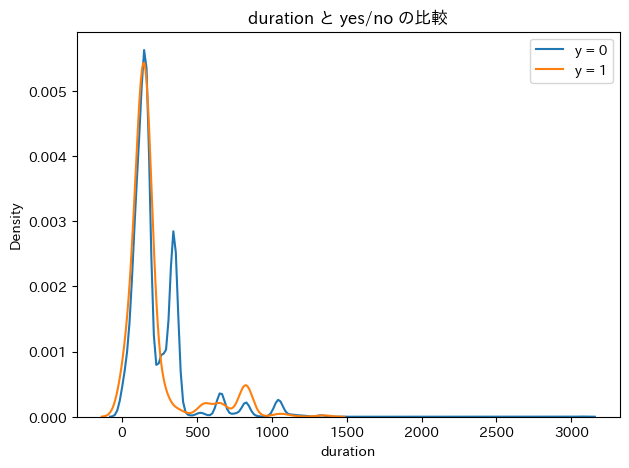

duration
158     5759
345     4601
101     1987
152     1663
121     1578
        ... 
145        1
156        1
306        1
95         1
1103       1
Name: count, Length: 140, dtype: int64

In [85]:
# duration と yes/no の比較
plt.figure(figsize=(7, 5))
sns.kdeplot(df_train[df_train['y'] == 0]['duration'], label='y = 0')
sns.kdeplot(df_train[df_train['y'] == 1]['duration'], label='y = 1')
plt.legend()
plt.title('duration と yes/no の比較')
plt.xlabel('duration')
plt.show()
df_train['duration'].value_counts()

In [86]:
df_train.nlargest(100, 'duration')

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
613,613,37,technician,married,secondary,no,86463,yes,no,unknown,16,may,3076,1,835,0,unknown,0
8821,8821,30,technician,married,secondary,no,52334,yes,no,unknown,23,may,3076,1,600,0,unknown,0
10847,10847,35,technician,married,secondary,no,101104,yes,no,unknown,26,may,3076,2,72,0,unknown,0
18668,18668,31,technician,single,secondary,no,6985,yes,no,unknown,16,may,3076,3,490,0,unknown,0
21833,21833,37,technician,single,secondary,no,63590,yes,no,unknown,16,may,3076,2,444,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,976,30,housemaid,married,primary,no,81895,no,no,unknown,20,jun,1133,1,728,0,unknown,0
1969,1969,41,entrepreneur,married,secondary,no,75337,no,no,unknown,2,jun,1133,1,536,0,unknown,0
2537,2537,51,technician,married,secondary,no,92894,yes,yes,unknown,2,jun,1133,3,776,0,unknown,0
3751,3751,37,admin.,married,tertiary,no,38454,yes,no,unknown,2,jun,1133,1,97,0,unknown,0


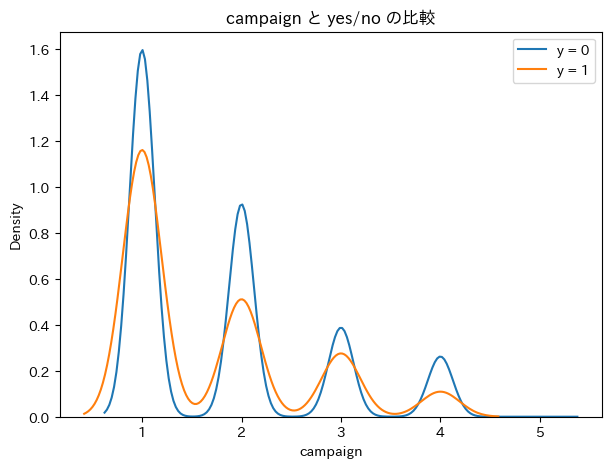

campaign
1    13769
2     7815
3     3339
4     2176
5        1
Name: count, dtype: int64

In [87]:
# campaign と yes/no の比較
plt.figure(figsize=(7, 5))
sns.kdeplot(df_train[df_train['y'] == 0]['campaign'], label='y = 0')
sns.kdeplot(df_train[df_train['y'] == 1]['campaign'], label='y = 1')
plt.legend()
plt.title('campaign と yes/no の比較')
plt.xlabel('campaign')
plt.show()
df_train['campaign'].value_counts()

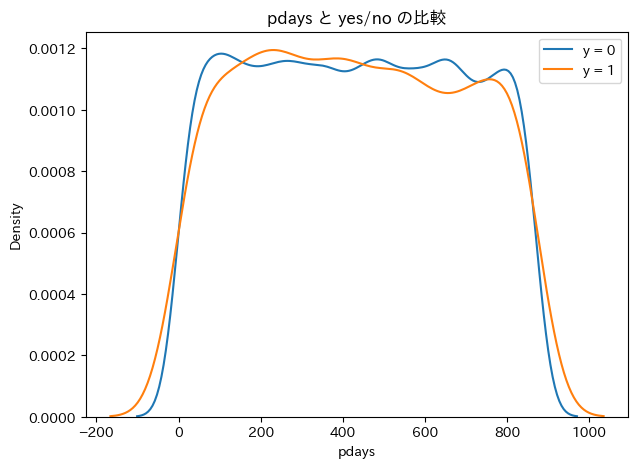

pdays
584    53
711    48
479    48
7      46
167    45
       ..
589    18
177    18
727    17
338    16
718    16
Name: count, Length: 872, dtype: int64

In [88]:
# pdays と yes/no の比較
plt.figure(figsize=(7, 5))
sns.kdeplot(df_train[df_train['y'] == 0]['pdays'], label='y = 0')
sns.kdeplot(df_train[df_train['y'] == 1]['pdays'], label='y = 1')
plt.legend()
plt.title('pdays と yes/no の比較')
plt.xlabel('pdays')
plt.show()
df_train['pdays'].value_counts()

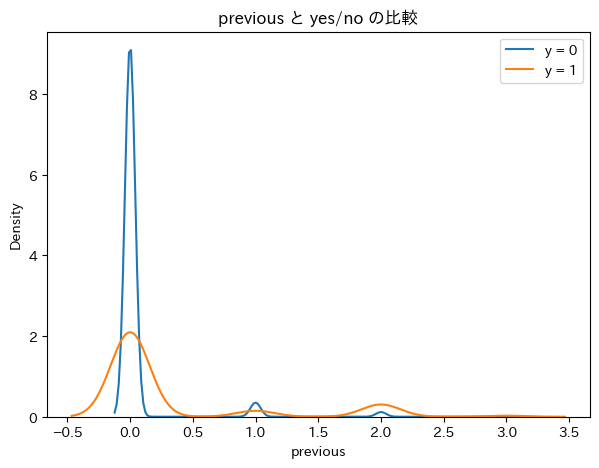

previous
0    25461
1     1023
2      548
3       68
Name: count, dtype: int64

In [89]:
# previous と yes/no の比較
plt.figure(figsize=(7, 5))
sns.kdeplot(df_train[df_train['y'] == 0]['previous'], label='y = 0')
sns.kdeplot(df_train[df_train['y'] == 1]['previous'], label='y = 1')
plt.legend()
plt.title('previous と yes/no の比較')
plt.xlabel('previous')
plt.show()
df_train['previous'].value_counts()

<Axes: >

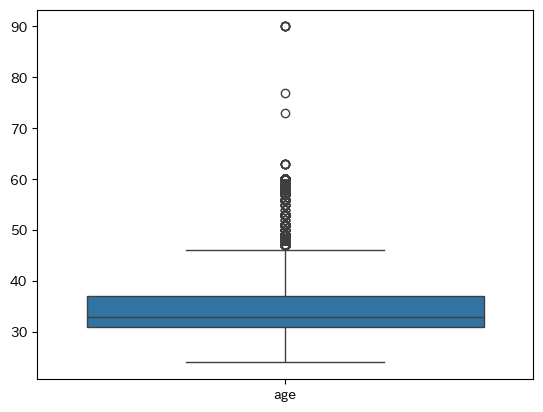

In [92]:
sns.boxplot(data=[df_train[df_train['y'] == 0]['age'], df_train[df_train['y'] == 1]['age']]) 
#sns.stripplot(data=[data1, data2], jitter=True, color='black')

In [90]:
data = pd.concat([df_train, df_test], sort=False)

# デカすぎるのに固定の値になってるのはなんかおかしいんじゃないかと思ってNaN

data.loc[data['duration'] >= 1000, 'duration'] = np.nan

# 値を変更しているので、変更前にしないとうまく検索できない

# 欠損値であることを主張してみる

#data['isUnknownEducation'] = data['education']=='unknown'
#data['isUnknownContact'] = data['contact']=='unknown'
#data['isUnknownPoutcome'] = data['poutcome']=='unknown'

#edu_unknown = data['education'].eq('unknown').sum()
#con_unknown = data['contact'].eq('unknown').sum()
#pou_unknown = data['poutcome'].eq('unknown').sum()

#data['unknownCount'] = edu_unknown + con_unknown + pou_unknown

# 働いていないことを主張してみる

data['isNotWorking'] = (data['job']=='unemployed') | (data['job']=='retired')

# no yes を 0 と 1 に変更
data['default'].replace(['no', 'yes'], [0, 1], inplace=True)
data['housing'].replace(['no', 'yes'], [0, 1], inplace=True)
data['loan'].replace(['no', 'yes'], [0, 1], inplace=True)

from sklearn.preprocessing import LabelEncoder
job_le = LabelEncoder()
data['job'] = job_le.fit_transform(data['job'])
marital_le = LabelEncoder()
data['marital'] = marital_le.fit_transform(data['marital'])
education_le = LabelEncoder()
data['education'] = education_le.fit_transform(data['education'])
housing_le = LabelEncoder()
data['housing'] = housing_le.fit_transform(data['housing'])
loan_le = LabelEncoder()
data['loan'] = loan_le.fit_transform(data['loan'])
contact_le = LabelEncoder()
data['contact'] = contact_le.fit_transform(data['contact'])
poutcome_le = LabelEncoder()
data['poutcome'] = poutcome_le.fit_transform(data['poutcome'])

# 月は意味ありげに使えそうなので、そのまま変換しておく

data['month'] = data['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}).astype(int)

# pdaysは-1とそれ以外で分ける
#data.loc[data['pdays']>=0, 'pdays'] = 1 
#data.loc[~data['pdays']>=0, 'pdays'] = 0

# 使わない奴を落とす

# delete_columns = ['balance', 'month', 'age', 'day', 'campaign', 'duration']

#data.drop(delete_columns, axis=1, inplace=True)


NameError: name 'np' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train = data[:len(df_train)]
test = data[len(df_train):]

y_train = train['y'].astype(int)
X_train = train.drop('y', axis=1)
X_test = test.drop('y', axis=1)

print(X_train.head())

   id  age  job  marital  education  default  balance  housing  loan  contact  \
0   0   31    7        1          1        0    12294        1     0        0   
1   1   29    2        2          2        0    43027        0     0        0   
2   2   35    4        1          2        0    12252        1     0        0   
3   3   31    9        1          1        0    99121        1     1        2   
4   4   48   10        1          0        0    42005        1     0        1   

   day  month  duration  campaign  pdays  previous  poutcome  isNotWorking  
0   21     11     101.0         3    498         0         1         False  
1   22      8     158.0         2    702         0         3         False  
2   11     11     351.0         1    826         0         0         False  
3   16      5     658.0         2    120         0         0         False  
4    3      4     177.0         1    273         0         3          True  


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [ ]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'previous', 'isNotWorking']

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import numpy as np

In [ ]:
FOLD = 5
NUM_ROUND = 1000

params = {
    'objective': 'binary'
}

valid_scores = []
models = []

kf = KFold(n_splits=FOLD, shuffle=True, random_state=0)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X_train)):
    X_t, X_v = X_train.iloc[train_indices], X_train.iloc[valid_indices]
    y_t, y_v = y_train.iloc[train_indices], y_train.iloc[valid_indices]

    lgb_train = lgb.Dataset(X_t, y_t, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_v, y_v, categorical_feature=categorical_features)
    
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), lgb.log_evaluation(0)])

    y_valid_pred = model.predict(X_v, num_iteration=model.best_iteration)

    score = roc_auc_score(y_v, y_valid_pred)

    print(f'fold {fold}, AUC: {score}')
    valid_scores.append(score)
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')



[LightGBM] [Info] Number of positive: 1178, number of negative: 13998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 974
[LightGBM] [Info] Number of data points in the train set: 15176, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077623 -> initscore=-2.475096
[LightGBM] [Info] Start training from score -2.475096
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.15242	valid_1's binary_logloss: 0.196342
fold 0, AUC: 0.8581263117725626
[LightGBM] [Info] Number of positive: 1178, number of negative: 13998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categorical_features)

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), lgb.log_evaluation(0)])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.167193	valid_1's binary_logloss: 0.204879


In [ ]:
sub = list(map(float, y_pred))
for idx, x in enumerate(sub):
    
    sub[idx] = [idx, x]

import csv

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(sub)